<a href="https://colab.research.google.com/github/alibaba0507/fx_arima_model/blob/main/ARIMA_Model_Predict_FX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install sklearn
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow scikit-learn

In [ ]:
!pip install pyopenssl

In [ ]:
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=5009c40663d2f0c2594abac01141840a923b8951fa30437d50f88a904b0664df
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
Process for : GBPJPY=x
[*********************100%***********************]  1 of 1 completed
Best Params: {'name': 'Best ARIMA', 'order': (2, 2, 1), 'seasonal_order': (2, 2, 1, 26), 'trend': 'n'}


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


'\nif hasEmail == True:\n  # Send the email\n  with smtplib.SMTP(smtp_server, smtp_port) as server:\n      server.starttls()\n      server.login(sender_email, sender_password)\n      server.send_message(msg)\n'

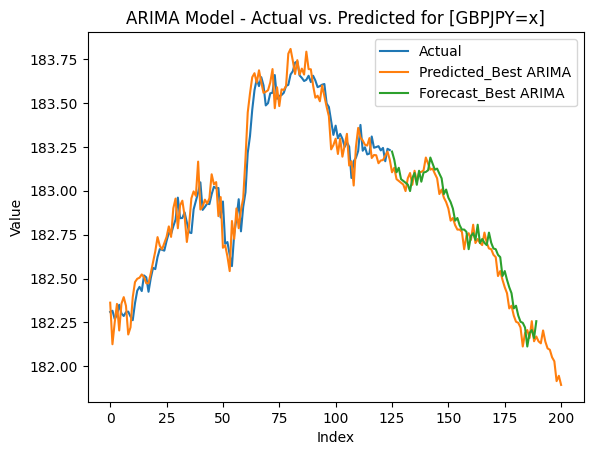

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
#from keras.models import Sequential
#from keras.layers import LSTM, Dense
import statsmodels.api as sm
import itertools
from sklearn.metrics import mean_absolute_error
!pip install pandas_ta
import pandas_ta as ta

import yfinance as yf


import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
import matplotlib.pyplot as plt
import ast
import gc
def get_data(symbol,start = "",end = "",period="", interval=""):
    """Get historical stock prices for the given symbol"""
    #stock_data = yf.download(tickers=symbol, start="2019-01-01", end="2023-04-27")
    if start != "" and end != "":
      stock_data = yf.download(tickers=symbol, start=start, end=end)
    if start != "" and end != "" and interval != "":
      stock_data = yf.download(tickers=symbol, start=start, end=end,interval=interval)
    if period != "" and interval != "":
      stock_data = yf.download(tickers=symbol, period=period, interval=interval)
    stock_data.reset_index(drop=True, inplace=True)
    return stock_data

def add_indicators_to_table(dt):
  dt["EMA_50"] = ta.ema(dt.Close, length=20)
  dt["SMA_100"] = ta.sma(dt.Close, length=100)
  dt['RSI_7']=ta.rsi(dt.Close, length=7)

  #this is the way to add indicator with multiple parameters (fields)
  my_bbands = ta.bbands(dt.Close, length=20, std=2)
  dt=dt.join(my_bbands)
  macd = ta.macd(dt.Close,fast=12,slow=2,signal=9)
  dt = dt.join(macd)
  dt.dropna(inplace=True)
  dt.reset_index(inplace=True)
  return dt


def create_sequences(data, seq_length):
    #data_array = data.to_numpy()  # Convert DataFrame to NumPy array
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Exclude the last column from features
        y.append(data[i + seq_length][:1])   # Use the first column as the target

    return np.array(X), np.array(y)

def reshape_arr(a):
  arr = np.array(a)
  reshaped_arr = np.squeeze(arr)
  return reshaped_arr

def create_prediction(params,forecast_steps = 50):
  my_array = []
  for best_params in params:
    final_model = None
    final_fitted_model = None
    print("Best Params:", best_params)
    # Fit the best model on the full dataset
    final_model = sm.tsa.ARIMA(endog=y_train_scaled, order=best_params['order'], seasonal_order=best_params['seasonal_order'],
                          trend=best_params['trend'])
    final_fitted_model = final_model.fit()
    # Update the model with new data

    #final_fitted_model = final_fitted_model.append(y_train_scaled[5420:5426])
    start_index = 5300
    end_index = 5500
    # Use the loaded ARIMA model to make predictions
    forecast = final_fitted_model.forecast(steps=forecast_steps) #
    predictions = final_fitted_model.predict(start=start_index, end=end_index)
    y_train_predictions_scaled = predictions.reshape(-1, 1)
    y_train_predictions = scaler.inverse_transform(y_train_predictions_scaled)
    y_train_forecast_scaled = forecast.reshape(-1, 1)
    y_train_forecast = scaler.inverse_transform(y_train_forecast_scaled)
    my_array.append({'name':best_params['name'],'prediction':y_train_predictions
                      ,'forecast':y_train_forecast})
    gc.collect()
  final_model = None
  final_fitted_model = None
  return my_array
#################################################### END Methods #######################################

symbols = [{'pair':'GBPJPY=x','precision':3},
           {'pair':'EURJPY=x','precision':3},
           {'pair':'AUDJPY=x','precision':3},
           {'pair':'CHFJPY=x','precision':3},
           {'pair':'USDJPY=x','precision':3},
          # {'pair':'GBPUSD=x','precision':5},
          # {'pair':'EURUSD=x','precision':5},
          # {'pair':'AUDUSD=x','precision':5},
          # {'pair':'NZDUSD=x','precision':5},
          # {'pair':'USDCAD=x','precision':5},
          # {'pair':'USDCHF=x','precision':5}
           ]
# Create a multipart message object
msg = MIMEMultipart()
hasEmail = False
for s in symbols:
  gc.collect()
  #usage
  symbol = s['pair']
  precision = s['precision'] # for all usd and 3 for JPY's
  print("Process for :", symbol)
  #usage
  #symbol = 'GBPJPY=x'
  #precision = 3 # for all usd and 3 for JPY's
  # Set the desired decimal precision for printing
  np.set_printoptions(precision=precision)
  df = get_data(symbol,"","","59d","15m")
  df = add_indicators_to_table(df)
  # Define the input features and output labels
  input_features = ['Close'
                  #  , 'SMA_100', 'BBU_20_2.0', 'BBL_20_2.0'
                    ]
  m = 0 # ending index of training data
  time_series = df.iloc[m:,df.columns.isin(input_features)] # get last records start from m upwords
  #time_series[['Close_P', 'SMA_100_P', 'BBU_20_2.0_P', 'BBL_20_2.0_P']] = 0
  data = time_series.reset_index(drop=True)
  data =  pd.DataFrame(data, dtype=float)
  # Step 1: Split the data into training and test sets
  # Assuming you have a time series dataset stored in a pandas DataFrame called 'data'
  train_size = int(len(data) * 1)
  train_data = pd.DataFrame(data[:train_size], dtype=float)
  test_data = pd.DataFrame(data[train_size:], dtype=float)
  data_array = train_data.to_numpy()
  X_train,y_train = create_sequences(data_array, 1)
  X_train = reshape_arr(X_train)
  y_train = reshape_arr(y_train)
  # Scale the training data
  scaler = MinMaxScaler()
  X_train_scaled =  scaler.fit_transform(X_train.reshape(-1, 1)) #scaler.fit_transform(X_train)
  y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)) #reshape_arr(scaler.fit_transform(y_train.reshape(-1, 1)))

  params = [{'name':"Best ARIMA", 'order': (2, 2, 1), 'seasonal_order': (2, 2, 1, 26), 'trend': 'n'},
            #{'name':"TREND ARIMA",'order': (0, 1, 2), 'seasonal_order': (0, 1, 2, 21), 'trend': 'n'},
            #{'name':"TREND ARIMA",'order':(0, 1, 0), 'seasonal_order': (2, 1, 2, 21), 'trend': 'n'},
            #{'name':"TREND ARIMA",'order': (3, 2, 4), 'seasonal_order': (3, 2, 5, 21), 'trend': 'n'},
            {'name':"TREND ARIMA",'order': (3, 2, 3), 'seasonal_order': (3, 2, 5, 13), 'trend': 'n'},

            #{'name':"TREND ARIMA",'order': (1, 2, 3), 'seasonal_order': (2, 1, 5, 13), 'trend': 'n'},
            #{'name':"TREND ARIMA - test error",'order': (0, 1, 2), 'seasonal_order': (0, 1, 2, 21), 'trend': 'n'},
             #{'name':"TREND ARIMA - test error 1",'order': (0, 1, 0), 'seasonal_order': (2, 2, 2, 21), 'trend': 'n'},
            #{'name':"TREND ARIMA - min error",'order': (3, 1, 3), 'seasonal_order': (3, 1, 3, 13), 'trend': 'n'},
            #{'name':"TREND ARIMA",'order': (3, 3, 3), 'seasonal_order': (3, 4, 3, 13), 'trend': 'n'},
            #{'name':"TREND ARIMA",'order': (2, 2, 1), 'seasonal_order': (3, 2, 3, 34), 'trend': 'n'},
            #{'order': (2, 1, 2), 'seasonal_order': (2, 2, 2, 26), 'trend': 'n'},
            #{'name':"TREND ARIMA", 'order': (5, 1, 3), 'seasonal_order': (3, 1, 3,  34), 'trend': 'n'},
           # {'name':"TREND ARIMA",'order': (3, 1, 3), 'seasonal_order': (3, 1, 5, 21), 'trend': 'n'},
            #{'name':"TREND ARIMA",'order': (2, 1, 2), 'seasonal_order': (1, 1, 5, 55), 'trend': 'n'},
            ]

  y_train_predictions = create_prediction(params,65)
  y_train_scaled_transformed = y_train_scaled.reshape(-1, 1)
  y_train_scaled_transformed = scaler.inverse_transform(y_train_scaled_transformed)


  # Convert the string representation back to a list
  #y_train_predictions_list = ast.literal_eval(y_train_predictions['data'])

  start_index = 0
  end_index = start_index + len(y_train_predictions[0]['prediction']) - 0
  import matplotlib.pyplot as plt
  # Clear the plot
  plt.clf()
  # Plot the actual values
  plt.plot(range(len(y_train_scaled_transformed[-125:])), y_train_scaled_transformed[-125:], label='Actual')
  actual_length = len(y_train_scaled_transformed[-125:])
  # Calculate the x-axis values for the predicted values

  cnt = 0
  for predictions in y_train_predictions:
      # Plot the predicted values with adjusted x-axis values
      plt.plot(range(start_index, end_index), predictions['prediction'][:end_index - start_index], label='Predicted_'+predictions['name'])
      predicted_x = range(actual_length, actual_length + len(predictions['forecast']))
      plt.plot(predicted_x, predictions['forecast'][:len(predicted_x)], label='Forecast_' + predictions['name'])
      cnt += 1

  # Add labels and title to the plot
  plt.xlabel('Index')
  plt.ylabel('Value')
  plt.title('ARIMA Model - Actual vs. Predicted for [' + symbol + ']')
  # Add a legend to the plot
  plt.legend()
  img_file = 'my_plot_' + symbol + '.png'
  # Save the plot as an image file
  plt.savefig(img_file)
  # Attach the plot image to the email
  with open(img_file, 'rb') as image_file:
      image = MIMEImage(image_file.read())
      msg.attach(image)
      hasEmail = True
  # Display the chart
  #plt.show()
# Email configuration
smtp_server = 'smtp.gmail.com'
smtp_port = 587
sender_email = 'ali.baba0507@gmail.com'
sender_password = 'csjtoiacsfiiilkw'
receiver_email = 'ali.baba0507@gmail.com'


msg['From'] = sender_email
msg['To'] = receiver_email
msg['Subject'] = 'Fx Prediction ARIMA Model'
'''
# Attach the plot image to the email
with open('my_plot.png', 'rb') as image_file:
    image = MIMEImage(image_file.read())
    msg.attach(image)
'''
'''
if hasEmail == True:
  # Send the email
  with smtplib.SMTP(smtp_server, smtp_port) as server:
      server.starttls()
      server.login(sender_email, sender_password)
      server.send_message(msg)
'''